# Analyse exploratoire et clustering

J'ai trouvé un datasets de données bancaire indienne. L'idée ici est de clusteriser les données. Je ne veux pas faire de la detection de fraude, j'aimerais plus faire un profilage de la tendance d'économie / dépenses des personnes riches / pauvres


Ce notebook réalise :
- Lecture, Modélisation exploration des données
- Prétraitement et normalisation des données
- Sélection automatique du nombre de clusters
- Clustering grace aux models KMeans, BayesianGaussianMixture et MeanShift
- Réduction de dimension (PCA 2D) et visualisation du résultats

## Import

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rich.progress import track
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler, OneHotEncoder

%matplotlib inline

## 1. Lecture et aperçu des données

In [4]:
file_path = './Data/bank_transactions.csv'
print(f"Lecture du fichier CSV depuis {file_path}")
df = pd.read_csv(file_path)
print('Dimensions :', df.shape)
df.head()


Lecture du fichier CSV depuis ./Data/bank_transactions.csv
Dimensions : (1048567, 9)


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


## 2. Statistiques descriptives et valeurs manquantes

In [5]:
print(df.describe(include='all'))
print('\nValeurs manquantes par colonne :')
print(df.isnull().sum())

       TransactionID CustomerID CustomerDOB CustGender CustLocation  \
count        1048567    1048567     1045170    1047467      1048416   
unique       1048567     884265       17254          3         9355   
top               T1   C5533885    1/1/1800          M       MUMBAI   
freq               1          6       57339     765530       103595   
mean             NaN        NaN         NaN        NaN          NaN   
std              NaN        NaN         NaN        NaN          NaN   
min              NaN        NaN         NaN        NaN          NaN   
25%              NaN        NaN         NaN        NaN          NaN   
50%              NaN        NaN         NaN        NaN          NaN   
75%              NaN        NaN         NaN        NaN          NaN   
max              NaN        NaN         NaN        NaN          NaN   

        CustAccountBalance TransactionDate  TransactionTime  \
count         1.046198e+06         1048567     1.048567e+06   
unique               

## 3. Visualisation des distributions et corrélations

Output()

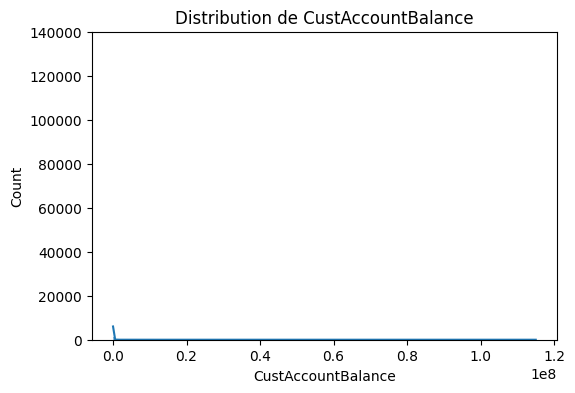

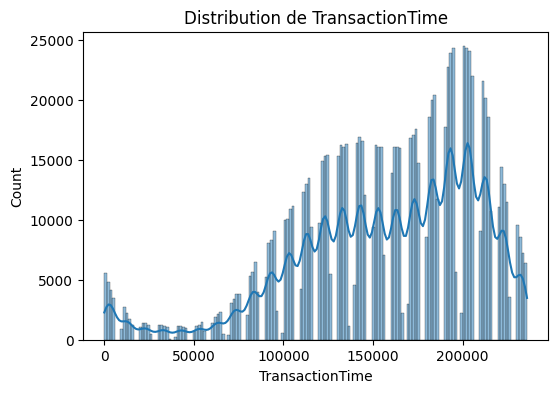

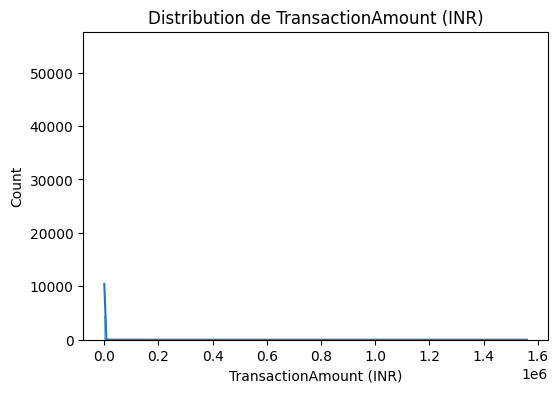

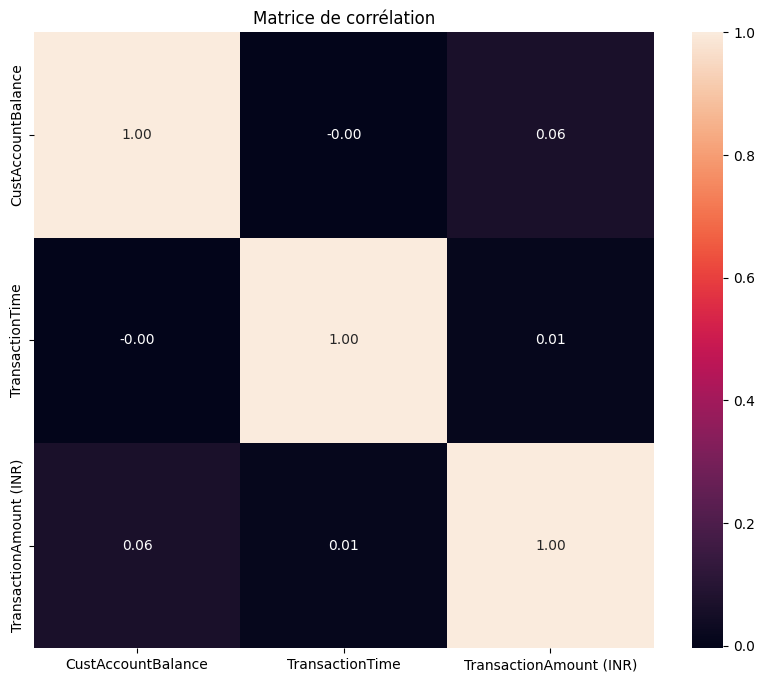

In [6]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in track(numeric_cols, description='Histogrammes'):
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution de {col}')
    plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f')
plt.title('Matrice de corrélation')
plt.show()

## 4. Prétraitement et normalisation

In [7]:
# Séparer colonnes numériques et catégorielles
cat_cols = df.select_dtypes(include=['object', 'category']).columns
num_cols = numeric_cols

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

X = preprocessor.fit_transform(df)
print('Prétraitement terminé. Forme de X :', X.shape)

Prétraitement terminé. Forme de X : (1048567, 1959502)


Le oneHotEncoder permet de ne pas transformer une colonne de ville par exemple en nombre. en effet si on choisit de convertir la colonne en nombre on dit qu'une ville peut etre superieur a une autre.

Plutot que supprimer les lignes qui ont des trous (valeurs vide) on peut Utilisé le simple imputer. Attention on peux grandement fausser la donnée sur des petites base de données. Ici on a 1 Millions de lignes donc le probleme ne se poses pas.

## 5. Sélection du nombre optimal de clusters

Output()

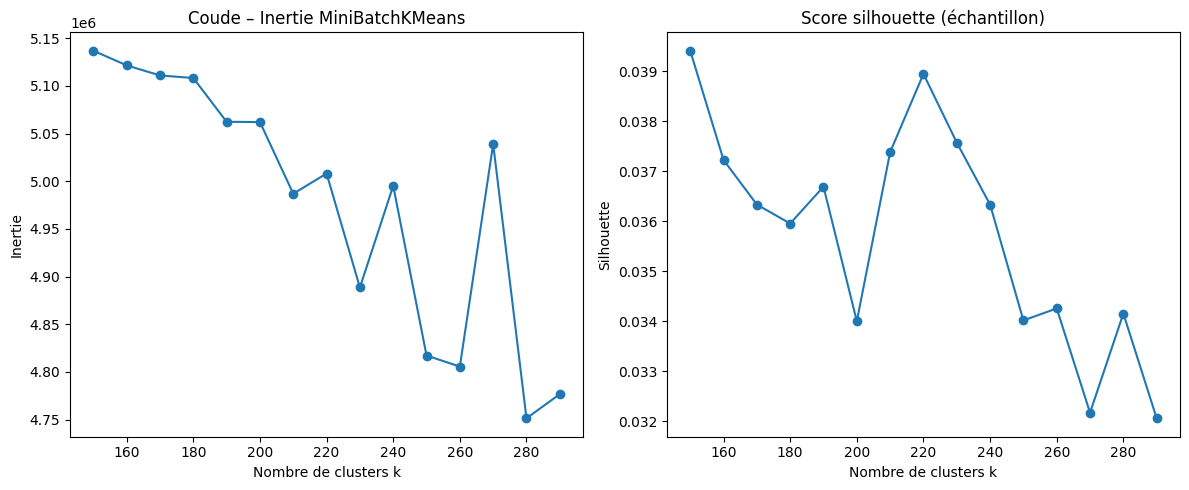

In [8]:
# Paramètres
k_range     = range(150, 300, 10)               # 150 à 299
sample_size = 20000                     # taille pour silhouette
batch_size  = 10000                     # pour MiniBatch
rng         = np.random.RandomState(42)

# Sous-échantillon fixe pour silhouette
idx       = rng.choice(X.shape[0], sample_size, replace=False)
X_sample  = X[idx]

inertias  = []
sil_scores = []

for k in track(k_range, description="Éval. MiniBatchKMeans"):
    mbk = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=batch_size,
        n_init=10
    )
    # fit sur tout X, plus rapide que KMeans
    labels = mbk.fit_predict(X)
    inertias.append(mbk.inertia_)
    # silhouette sur l'échantillon
    sil = silhouette_score(X_sample, mbk.predict(X_sample))
    sil_scores.append(sil)

# Affichage des courbes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(k_range), inertias, marker='o')
plt.title("Coude – Inertie MiniBatchKMeans")
plt.xlabel("Nombre de clusters k")
plt.ylabel("Inertie")

plt.subplot(1, 2, 2)
plt.plot(list(k_range), sil_scores, marker='o')
plt.title("Score silhouette (échantillon)")
plt.xlabel("Nombre de clusters k")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()

Ici on sait qu'on cherche des clusters mais on ne sait pas combien. Or le model Kmeans a besoin d'un nombre définis de cluster.

Pour des soucis de performance on n'utilise pas Kmeans mais miniBatchKmeans. Il est plus petit donc converge plus vite bien qu'un peu moins précis que le kmeans.
Il permet aussi l'entrainement par batch pour aller plus vite.

On essaie donc de trouver le meilleur nombre de cluster entre 150 et 300 par pas de 10. On compare ensuite tous les essaie grace au score silhouette.

## 6. Clustering avec les modèles KMeans, BayesianGMM and MeanShift

In [ ]:
best_k = k_range[sil_scores.index(max(sil_scores))]
print(f"Meilleur k selon silhouette : {best_k}")

models = {
    'KMeans': KMeans(n_clusters=best_k, random_state=42),
    'BayesianGMM': BayesianGaussianMixture(n_components=best_k, random_state=42),
    # 'MeanShift': MeanShift()
}
results = {}

# Limite de la taille d'échantillon pour MeanShift
max_sample_size = 50000
if X.shape[0] > max_sample_size:
    X_mean_shift = X[:max_sample_size]
else:
    X_mean_shift = X

for name, model in track(models.items(), description='Entraînement'):
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    results[name] = {'labels': labels, 'silhouette': score}
    print(f"{name} : Silhouette = {score:.3f}")

Output()

Meilleur k selon silhouette : 150


Maintenant qu'on a déterminé le nombre de clusters on va pouvoir prendre le k_optimal (nombre optimale de cluster) et entrainer tous les models. Cela peux prendre un peu de temps.

Pour les models on a donc le Kmeans, Le BayesianGaussianMixture, et le MeanShift
J'ai commenter le Meanshitf car il est trop gourmand en calcule et donc en temps. Il prends un centre de cluster et calcule la distance de chaque point. ensuite il passes au deuxieme centre etc etc. Avec ce model il est déconseiller de dépasser 50 000 lignes.

Le BayesianGaussianMixture est lui aussi couteux en calculs mais moins que le MeanShift. On part avec un grand nombre de clusters (ex: 10) ensuite chaque cluster a un poids qui lui ai donnée par calcule. On fois le premier passages fait un retire les clusters qui utilise aucune donnée (poids a 0) et on recommence le traitement des données et ce jusqu'a ce que plus rien ne bouge. A ce moment la on a le nombre de cluster ainsi que les données clusterisé.

Une fois entrainer on print les score_silhouette des 3 models sélectionné afin de les comparer entre eux.

## 7. PCA 2D et visualisation des clusters

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

for name, res in results.items():
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x='PC1', y='PC2', hue=res['labels'], palette='tab10', data=df_pca, legend='full')
    plt.title(f'Clusters PCA 2D - {name}')
    plt.show()


J'utilise une PCA afin de pouvoir afficher en 2D mon graphique qui permet de voir quelques clusters représentent quoi. 